# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

## Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* reward (int) - (numeric): money awarded for the amount spent: reward given for completing an offer
* channels (list of strings) - (categorical): web, email, mobile, social
* difficulty (int) - (numeric): minimum required spend to complete an offer
* duration (int) - (numeric): time for offer to be open, in days
* offer_type (string) - (categorical): type of offer ie BOGO, discount, informational
* id (string) - offer id

**profile.json**
* gender (str) - (categorical): M, F, O, or null: gender of the customer ('O' for other rather than M or F)
* age (int) - (numeric): missing value encoded as 118: age of the customer
* id (str) - (string/hash): customer id
* became_member_on (int) - (date) format YYYYMMDD: date when customer created an app account
* income (float) - (numeric): customer's income

**transcript.json**
* person (str) - (string/hash): customer id
* event (str) - (categorical): record description (ie transaction, offer received, offer viewed, offer completed)
* value (dictionary) - different values depending on event type:
    * offer id (string/hash): not associated with any "transaction")
    * amount (numeric): money spent in "transaction"
    * reward (numeric): money gained from "offer completed"
* time (int) - (numeric): time in hours since start of test (the data begins at time t=0)

## Exploratory data analysis

### Import necessary packages

We will start by importing necessary packages. The majority of the data wrangling will be done using pandas, visualizations will be done using matplotlib and Machine Learning part using scikit-learn.

### Set Pandas options

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
from warnings import simplefilter

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Display plots in the notebook
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 30)

In [4]:
# Suppress future warnings
simplefilter(action='ignore', category=FutureWarning)

### Read in the JSON files

Next, we'll read in the data and have a look at its structure.

In [5]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [6]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
# Missing values per column 
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [10]:
# Check if missing values are scattered or always per row 
profile.loc[profile['gender'].isna(), 'income'].isna().sum() == profile.loc[profile['age'] == 118, 'income'].isna().sum()

True

In [11]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


There are 2175 missing values in the profile file, all rows with missing gender also have missing age and income.
There are no missing values in the transcript or portfolio files.

## Transform data

Next step will be to transform the data: encoding string IDs with simple numerical labels, expanding nested columns and substituting numerical dummy variables for categorical ones.

### Portfolio

In [13]:
# Create a LabelEncoder object
le_offer_id = LabelEncoder()
# Fit and transform string offer IDs to numerical values
le_offer_id.fit(pd.concat([portfolio['id'], pd.Series(np.nan)]))
encoded_offer_id = le_offer_id.transform(portfolio['id'])
portfolio['id'] = encoded_offer_id
portfolio.rename(columns={'id': "offer_id"}, inplace=True)

In [14]:
channels = ['web', 'email', 'mobile', 'social']
for channel in channels:
    portfolio['channel_' + channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
portfolio.drop(columns='channels', inplace=True)

In [15]:
portfolio = pd.get_dummies(portfolio, columns=['offer_type'], dtype=np.uint8)

In [16]:
portfolio

,reward,difficulty,duration,offer_id,channel_web,channel_email,channel_mobile,channel_social,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,7,0,1,1,1,1,0,0
1,10,10,5,4,1,1,1,1,1,0,0
2,0,0,4,3,1,1,1,0,0,0,1
3,5,5,7,6,1,1,1,0,1,0,0
4,5,20,10,0,1,1,0,0,0,1,0
5,3,7,7,1,1,1,1,1,0,1,0
6,2,10,10,9,1,1,1,1,0,1,0
7,0,0,3,5,0,1,1,1,0,0,1
8,5,5,5,8,1,1,1,1,1,0,0
9,2,10,7,2,1,1,1,0,0,1,0


### Profile

In [17]:
# Create a LabelEncoder object
le_person = LabelEncoder()
# Fit and transform person string IDs to numerical values
encoded_person = le_person.fit_transform(profile['id'])
profile['id'] = encoded_person
profile.rename(columns={'id': "person_id"}, inplace=True)

In [18]:
# Drop all missing values from profile
profile.dropna(inplace=True, ignore_index=True)

In [19]:
# Replace the membership start date with the amount of days since that date 
profile['member_since_days'] = (pd.Timestamp.today() - pd.to_datetime(profile['became_member_on'].astype('str'))).dt.days
profile.drop(columns='became_member_on', inplace=True)

In [20]:
# Get dummy variables for the only categorical gender column
profile = pd.get_dummies(profile, dtype=np.uint8)

In [21]:
# Replace missing income and age values (coded as 118) with -1 (not needed if missing values have been dropped)
profile.fillna(-1, inplace=True)
profile['age'].replace(118, -1, inplace=True)

In [22]:
# Sort by person ID
profile.sort_values('person_id', inplace=True)

In [23]:
profile.head()

,age,person_id,income,member_since_days,gender_F,gender_M,gender_O
3279,33,0,72000.0,2191,0,1,0
3639,40,2,57000.0,1928,0,0,1
2220,59,3,90000.0,2604,1,0,0
7347,24,4,60000.0,2352,1,0,0
8827,26,5,73000.0,2130,1,0,0


### Transcript

In [24]:
# Expand the value column into separate columns
transcript = pd.concat([transcript, pd.json_normalize(transcript['value'])], axis=1).drop(columns='value')
transcript['offer_id'].fillna(transcript['offer id'], inplace=True)
transcript.drop(columns='offer id', inplace=True)

In [25]:
# Transform the string IDs to numerical values
transcript['offer_id'] = le_offer_id.transform(transcript['offer_id'])
transcript['person'] = le_person.transform(transcript['person'])
transcript.rename(columns={'person': "person_id"}, inplace=True)

In [26]:
# Get dummy variables for the categorical event column
# pd.get_dummies(transcript, columns=['event'])

In [27]:
# Replace spaces in columns names with underscores (not needed if the event column has not been expanded)
transcript.columns = transcript.columns.str.replace(' ', '_')

In [28]:
# Fill missing values
transcript.fillna(0, inplace=True)

In [29]:
# Sort by person ID
transcript.sort_values('person_id', inplace=True)

In [30]:
transcript.head()

,person_id,event,time,amount,offer_id,reward
302205,0,transaction,696,18.41,10,0.0
168412,0,transaction,414,8.57,10,0.0
300930,0,transaction,690,28.16,10,0.0
55972,0,offer received,168,0.00,5,0.0
153401,0,offer received,408,0.00,8,0.0


### Calculate conversion success

Conversion status will be calculated  as successful if the following formula is true: $OfferReceivedTime < OfferViewedTime < OfferCompletedTime$.

In [31]:
# Group and pivot the transcript dataframe
grouped = transcript.groupby(['person_id', 'offer_id', 'event'])['time']
conversion_df = grouped.min().unstack().reset_index()
conversion_df.columns = conversion_df.columns.str.replace(' ', '_')
conversion_df.columns.name = None
conversion_df.head()

,person_id,offer_id,offer_completed,offer_received,offer_viewed,transaction
0,0,2,576.0,576.0,NaN,NaN
1,0,3,NaN,336.0,372.0,NaN
2,0,5,NaN,168.0,192.0,NaN
3,0,8,414.0,408.0,456.0,NaN
4,0,9,528.0,504.0,540.0,NaN


In [32]:
# Assess the conversion status
conversion_df['conversed'] = conversion_df.apply(lambda x: 1 if (x['offer_received'] < x['offer_viewed']) and (x['offer_viewed'] < x['offer_completed']) else 0, axis='columns')
conversion_df.drop(columns=['offer_completed', 'offer_received', 'offer_viewed', 'transaction'], inplace=True)
conversion_df.head()

,person_id,offer_id,conversed
0,0,2,0
1,0,3,0
2,0,5,0
3,0,8,0
4,0,9,0


### Merge dataframes

Now the data has been transformed, it will be merged into a single dataframes, containing all the features which will be used to make predictions. 

In [33]:
profile_conversion = profile.merge(conversion_df, how='left', on='person_id')
conversion_df = conversion_df.loc[conversion_df['offer_id'] != 10]    # drop all rows associated with transaction event
profile_conversion.head()

,age,person_id,income,member_since_days,gender_F,gender_M,gender_O,offer_id,conversed
0,33,0,72000.0,2191,0,1,0,2,0
1,33,0,72000.0,2191,0,1,0,3,0
2,33,0,72000.0,2191,0,1,0,5,0
3,33,0,72000.0,2191,0,1,0,8,0
4,33,0,72000.0,2191,0,1,0,9,0


In [34]:
full_df = profile_conversion.merge(portfolio, how='left', on='offer_id')
full_df.dropna(inplace=True, ignore_index=True)
full_df.head()

,age,person_id,income,member_since_days,gender_F,gender_M,gender_O,offer_id,conversed,reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social,offer_type_bogo,offer_type_discount,offer_type_informational
0,33,0,72000.0,2191,0,1,0,2,0,2.0,10.0,7.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
1,33,0,72000.0,2191,0,1,0,3,0,0.0,0.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,33,0,72000.0,2191,0,1,0,5,0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,33,0,72000.0,2191,0,1,0,8,0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,33,0,72000.0,2191,0,1,0,9,0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


## Train ML models and make predictions

In this project I was mostly interested in one question: how can we predict if an individual will respond to an offer based on their demographic information and offer type. I will use all the available features to predict the binary conversion variable.

To begin, I will split the full dataset into train and test sets and scale non-binary features.

In [35]:
# Select features used to train models
X = full_df.drop(columns=['person_id', 'offer_id', 'conversed'])
y = full_df['conversed']

In [36]:
# Split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Scale age, income and membership tenure features
scaler = StandardScaler()
features_to_scale = ['age', 'income', 'member_since_days', 'reward', 'difficulty', 'duration']
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

In [38]:
# Undersample data to obtained non-biased dataset
# rus = RandomUnderSampler(random_state=42)
# X_train_scaled_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

Next, I will compare 7 ML models from the scikit-learn library using default hyper-parameters:

1. Logistic Regression
2. Random Forest Classifier
3. K-Neighbors Classifier
4. Extra Trees Classifier
5. Ada Boost Classifier
6. Gradient Boosting Classifier
7. Support Vector Classifier

I will use the following helper function to do so.

In [83]:
def fit_predict(model):
    """
    Fit a ML model to training data, predict using test data and store predictions and model metrics in a dictionary.
    Args:
        model: ML model
    Return:
        prediction: predictaed label for the test dataset
        report: model metrics
    """
    model.fit(X_train, y_train)
    predictions = pd.Series(model.predict(X_test))
    class_report = classification_report(y_test, predictions, output_dict=True)
    report_summary = {
        'accuracy': class_report['accuracy'],
        'f1_macro_avg': class_report['macro avg']['f1-score'],
        'f1_weighted_avg': class_report['weighted avg']['f1-score']
    }
    report = pd.Series(report_summary)
    
    return predictions, report

Next I will initialize the models mostly with default parameters and create a model dictionary

In [71]:
lr = LogisticRegression(max_iter=200, random_state=42)
rfc = RandomForestClassifier(random_state=42)
knc = KNeighborsClassifier()
etc = ExtraTreesClassifier(random_state=42)
abc = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
svc = SVC(random_state=42)

model_dict = {
    'lr': lr,
    'rfc': rfc,
    'knc': knc,
    'etc': etc,
    'abc': abc,
    'gbc': gbc,
    'svc': svc
}

Finally, I will call the helper function to train all the model, make prediction and compare results.

In [88]:
pred_dict = {}
report_dict = {}

for model_name, model in model_dict.items():
    preds, report = fit_predict(model)
    pred_dict[model_name] = preds
    report_dict[model_name] = report

pred_df = pd.concat(pred_dict, axis=1)
report_df = pd.concat(report_dict, axis=1)

In [93]:
report_df

,lr,rfc,knc,etc,abc,gbc,svc
accuracy,0.772929,0.749298,0.738615,0.744319,0.771299,0.775555,0.773291
f1_macro_avg,0.508269,0.570528,0.576624,0.566066,0.528108,0.560511,0.481285
f1_weighted_avg,0.704208,0.721025,0.718864,0.717124,0.712104,0.727486,0.692670


As we can see from the above report all the models perform very similarly.

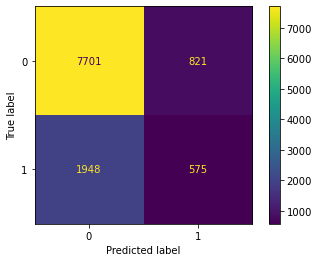

In [97]:
ConfusionMatrixDisplay(confusion_matrix(y_test, pred_df['rfc'])).plot()

What we can see above is a confusion matrix for the Random Forest Classifier. The matrices for the other models look very similar. From it we can see that with a decent accuracy we can predict when someone will not respond to an offer. However there's much room for improvement for positive case prediction.

This notebook shows the whole data science process from loading and cleaning the data to making predictions using machine learning algorithms and visualizing the results.